## seaborn

/opt/anaconda3/envs/scvi-env-arm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/ql/mhz506t52bjgn30w6f4wqhv40000gn/T/ipykernel_6331/1454120883.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata_subset.obs['Cell type annotation'].fillna('Non Differentiated', inplace=True)


data shape (9220, 64)
labels shape 9220


NameError: name 'output_dir' is not defined

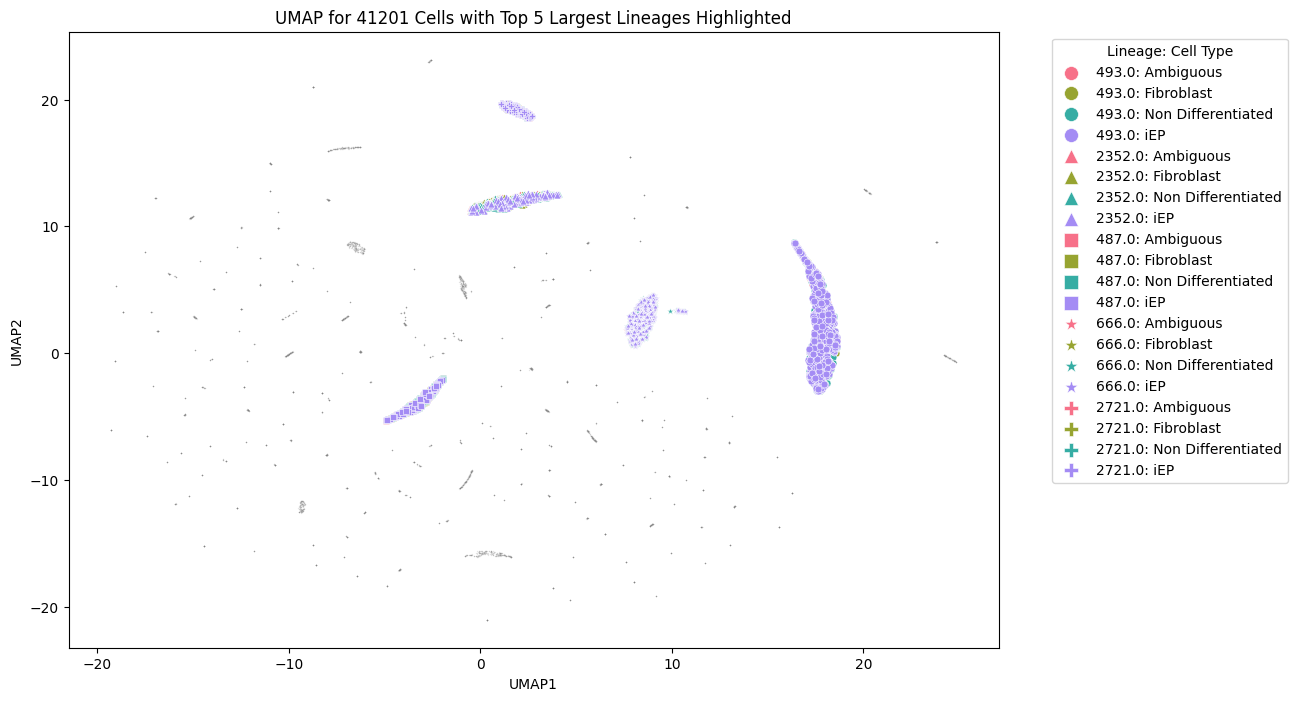

In [1]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from collections import Counter
import anndata as ad
import seaborn as sns

input_dir = "/Users/apple/Desktop/KB/data"
# output_dir = "/Users/apple/Desktop/KB/SCSeq_LineageBarcoding2/SCSeq_LineageBarcoding/SCLineage_ConstrativeLearning/out/plot/feat_713_colab"
num_top_lg_toplot = 5

# Load dataset
data = np.load(input_dir+'/feat_train_test/biddy/bs30_sf0025/scBaseEncoderFeat_Z_bs30_tau0.5.npy')
adata_subset = ad.read_h5ad(input_dir+'/BiddyData/Biddy_train.h5ad')
adata_subset.obs['Cell type annotation'] = adata_subset.obs["cell_type"]
adata_subset.obs['Cell type annotation'] = adata_subset.obs['Cell type annotation'].cat.add_categories('Non Differentiated')
# Replace NaN values with 'Non Differentiated'
adata_subset.obs['Cell type annotation'].fillna('Non Differentiated', inplace=True)
labels = adata_subset.obs["clone_id"].to_numpy()
num_cells = labels.shape[0]

categories = adata_subset.obs['Cell type annotation'].to_numpy()

print("data shape", data.shape)
print("labels shape", num_cells)

# Initialize UMAP and fit the data
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

# Determine the top lineages
unique_labels, counts = np.unique(labels, return_counts=True)
top_lineages = unique_labels[np.argsort(-counts)[:num_top_lg_toplot]]

# Define category to color mapping
unique_categories = np.unique(categories)
colors = sns.color_palette('husl', len(unique_categories))
category_to_color = dict(zip(unique_categories, colors))

default_color = 'gray'

# Define marker shapes
marker_shapes = ['o', '^', 's', '*', 'P']  # circle, triangle, square, star, pentagon

plt.figure(figsize=(12, 8))

# Plot all other lineages first
for label in np.unique(labels):
    if label not in top_lineages:
        subset = embedding[labels == label]
        sns.scatterplot(x=subset[:, 0], y=subset[:, 1], color=default_color, s=1, alpha=0.2)

# Plot the top lineages with different shapes
for i, lineage in enumerate(top_lineages):
    subset = embedding[labels == lineage]
    subset_categories = categories[labels == lineage]
    for category in np.unique(subset_categories):
        sns.scatterplot(x=subset[subset_categories == category][:, 0], 
                        y=subset[subset_categories == category][:, 1], 
                        color=category_to_color[category], 
                        marker=marker_shapes[i], 
                        s=25, 
                        alpha=1, 
                        label=f'{lineage}: {category}')

plt.title(f'UMAP for 41201 Cells with Top 5 Largest Lineages Highlighted')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Create a legend for the categories present in the specific lineage
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Lineage: Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=2)

plt.savefig(output_dir + 'cell_umap_top_5_largest_plot.png', dpi=300)
plt.show()
